In [1]:
import string
import re
import time as t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool, cpu_count
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
!pip install clean-text
import cleantext

from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder

!pip install langdetect
from langdetect import detect


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\85369\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\85369\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\85369\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\85369\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Reading the data into pandas DataFrames
training_df = pd.read_excel('./northern-europe-datamining/training_data.xlsx', engine='openpyxl')
test_df = pd.read_excel('./northern-europe-datamining/test_data.xlsx', engine='openpyxl')


In [3]:
def decode_full_text(full_text):
  return eval(full_text).decode('utf-8')

def descriptive_table(table):
  table = table.describe().rename(index={'50%': 'median', 'mean': 'average', 'min': 'minimum', 'max': 'maximum'})
  return table.loc[['minimum', 'average', 'median', 'maximum']]


In [4]:
training_df['full_text'] = training_df['full_text'].apply(decode_full_text)
test_df['full_text'] = test_df['full_text'].apply(decode_full_text)


In [5]:
# Calculating tweet length in characters and words
tweet_length_chars = training_df['full_text'].str.len()
tweet_length_words = training_df['full_text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

# Calculating hashtag length in characters and words
hashtag_length_chars = training_df['hashtags'].str.len()
hashtag_length_words = training_df['hashtags'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

length_df = pd.DataFrame()
length_df['tweet_length_chars'] = tweet_length_chars
length_df['tweet_length_words'] = tweet_length_words
length_df['hashtag_length_chars'] = hashtag_length_chars
length_df['hashtag_length_words'] = hashtag_length_words

descriptive_table_df = descriptive_table(length_df)

descriptive_table_df


,tweet_length_chars,tweet_length_words,hashtag_length_chars,hashtag_length_words
minimum,1.00000,1.000000,1.000000,0.000000
average,140.31248,20.284048,14.089948,0.492197
median,140.00000,19.000000,11.000000,0.000000
maximum,862.00000,89.000000,145.000000,16.000000


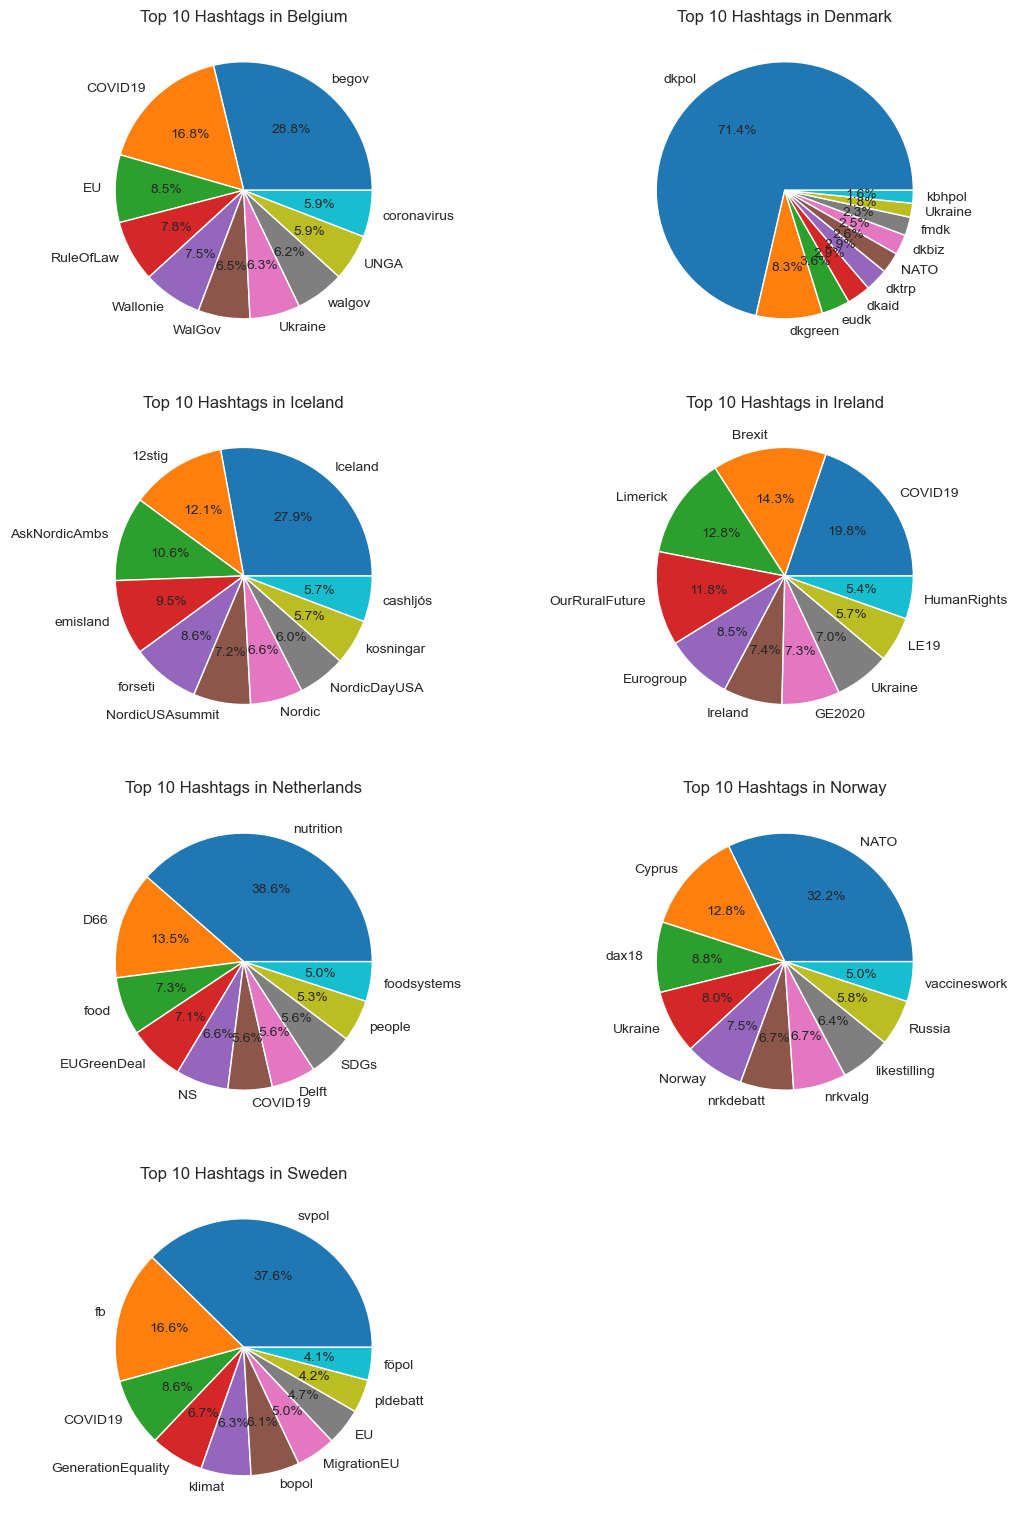

In [6]:
training_df_by_countries = training_df.dropna(subset=['hashtags']).groupby('country_user')
top_hashtags_by_country = {}

for country, columns in training_df_by_countries:
    top_hashtags = columns['hashtags'].str.split().explode().value_counts().head(10)
    top_hashtags_by_country[country] = top_hashtags

# Calculate the layout for subplots
n_countries = len(top_hashtags_by_country)
cols = 2  # for example, 3 columns
rows = n_countries // cols + (n_countries % cols > 0)

# Create a larger figure
plt.figure(figsize=(cols * 6.4, rows * 4.8))

# Create a pie chart for each country in a subplot
for idx, (country, top_hashtags) in enumerate(top_hashtags_by_country.items()):
    plt.subplot(rows, cols, idx + 1)  # Subplot for each country
    plt.pie(top_hashtags, labels=top_hashtags.index, autopct='%1.1f%%')
    plt.title(f'Top 10 Hashtags in {country.capitalize()}')

plt.show()


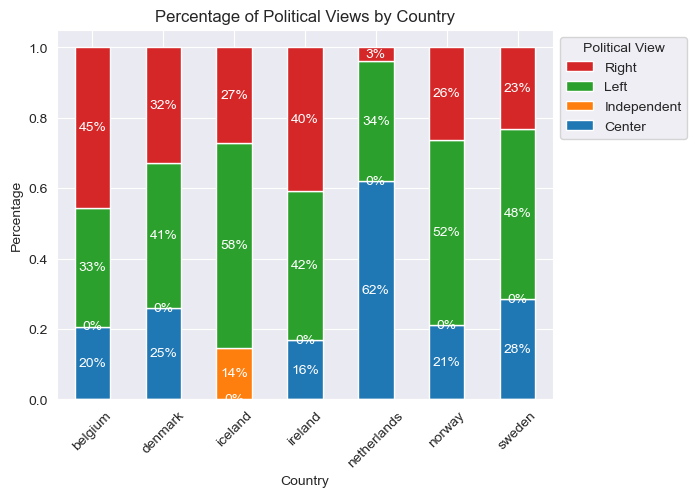

In [7]:
# Grouping data by country and political view
training_df_by_countries_views = training_df.groupby(['country_user', 'pol_spec_user']).size().unstack(fill_value=0)

# Normalizing the counts to get percentages
training_df_by_countries_views_normalized = training_df_by_countries_views.div(training_df_by_countries_views.sum(axis=1), axis=0)

# Plotting a stacked bar chart

ax = training_df_by_countries_views_normalized.plot(kind='bar', stacked=True)
plt.title('Percentage of Political Views by Country')
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

# Reversing the legend order to match the stack order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Political View', loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Add annotations for percentages
for x, y in enumerate([*training_df_by_countries_views.index.values]):
  for (proportion, y_loc) in zip(training_df_by_countries_views_normalized.loc[y], training_df_by_countries_views_normalized.loc[y].cumsum()):
    ax.text(x=x, y=(y_loc - proportion) + (proportion / 2), s=f'{int(proportion * 100)}%',
      color="white", ha="center", va="center")

plt.show()


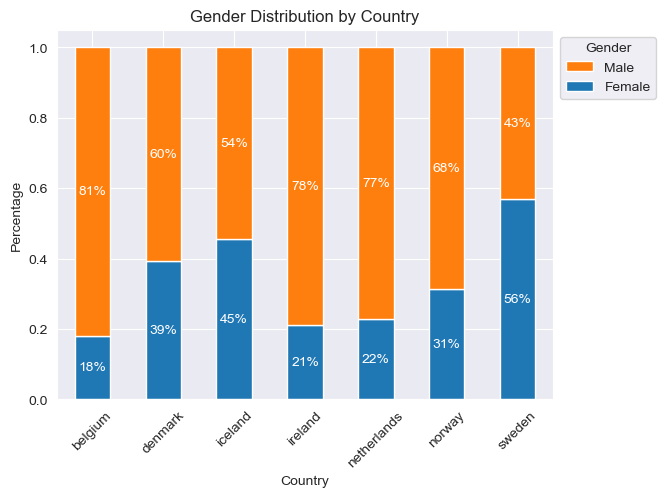

In [8]:
# Grouping data by country and political view
training_df_by_countries_views = training_df.groupby(['country_user', 'gender_user']).size().unstack(fill_value=0)

# Normalizing the counts to get percentages
training_df_by_countries_views_normalized = training_df_by_countries_views.div(training_df_by_countries_views.sum(axis=1), axis=0)

# Plotting a stacked bar chart

ax = training_df_by_countries_views_normalized.plot(kind='bar', stacked=True)
plt.title('Gender Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

# Reversing the legend order to match the stack order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Gender', loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Add annotations for percentages
for x, y in enumerate([*training_df_by_countries_views.index.values]):
  for (proportion, y_loc) in zip(training_df_by_countries_views_normalized.loc[y], training_df_by_countries_views_normalized.loc[y].cumsum()):
    ax.text(x=x, y=(y_loc - proportion) + (proportion / 2), s=f'{int(proportion * 100)}%',
      color="white", ha="center", va="center")

plt.show()


In [9]:
# Define the tweet_cleaner function
def tweet_cleaner(tweet):
  # Convert the tweet to lowercase
  tweet = tweet.lower()

  if tweet.startswith('rt'):
    tweet = tweet[2:]

  try:
    lang = detect(tweet)
  except:
    lang = 'en'

  if lang in stopwords.fileids():
    stop_words = set(stopwords.words(lang))
  else:
    stop_words = set(stopwords.words('english'))

  tweet = re.sub(r'https?\S*', '', tweet)

  # i) Remove stop words
  # ii) Delete all words that are 3 letters long or shorter
  tweet = ' '.join([word for word in tweet.split() if (len(word) >= 3) and (word not in stop_words)])

  tweet = cleantext.clean(tweet, no_emoji=True, no_punct=True)
  return tweet

# Load the  lemmatize_tweet() in the lemmatizer.py file
lemmatizer = WordNetLemmatizer()

# Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

# Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):
  # tokenize the tweet and find the POS tag for each token
  tweet = tweet_cleaner(tweet)
  nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))
  # tuple of (token, wordnet_tag)
  wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
  lemmatized_tweet = []
  for word, tag in wordnet_tagged:
    if tag is None:
      # if there is no available tag, append the token as is
      lemmatized_tweet.append(word)
    else:
      # else use the tag to lemmatize the token
      lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
  return ' '.join(lemmatized_tweet)


In [10]:
cpu_count()


32

In [ ]:
# Record the start time
start_time = t.time()

# Create a list of tweets from the DataFrame
tweets_list = training_df['full_text'].tolist()

# Create a Pool and map the parallelize_lemmatization function to each tweet
with Pool(processes=cpu_count()) as pool:
  text_clean = pool.map(lemmatize_tweet, tweets_list)

# Assign the cleaned tweets back to the DataFrame
training_df['text_clean'] = text_clean

# Stop the timer and report the elapsed time
end_time = t.time()
elapsed_time = end_time - start_time
print(f'The elapsed time is {elapsed_time}')


In [ ]:
# Save DataFrame
training_df.to_excel('./training_data_cleaned.xlsx', index=False)


In [ ]:
# Calculating cleaned tweet length in characters and words
tweet_cleaned_length_chars = training_df['text_clean'].str.len()
tweet_cleaned_words = training_df['text_clean'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

length_df['tweet_cleaned_length_chars'] = tweet_cleaned_length_chars
length_df['tweet_cleaned_length_words'] = tweet_cleaned_words

descriptive_table_df = descriptive_table(length_df)

descriptive_table_df


,tweet_length_chars,tweet_length_words,hashtag_length_chars,hashtag_length_words,tweet_cleaned_length_chars,tweet_cleaned_length_words
minimum,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000
average,140.31248,20.284048,14.089948,0.492197,103.482375,14.075882
median,140.00000,19.000000,11.000000,0.000000,101.000000,13.000000
maximum,862.00000,89.000000,145.000000,16.000000,778.000000,83.000000


Extracting tf-idf features for NMF...
done in 6.774s.
Extracting tf features for LDA...
done in 6.857s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=407223 and n_features=1000...
done in 7.956s.


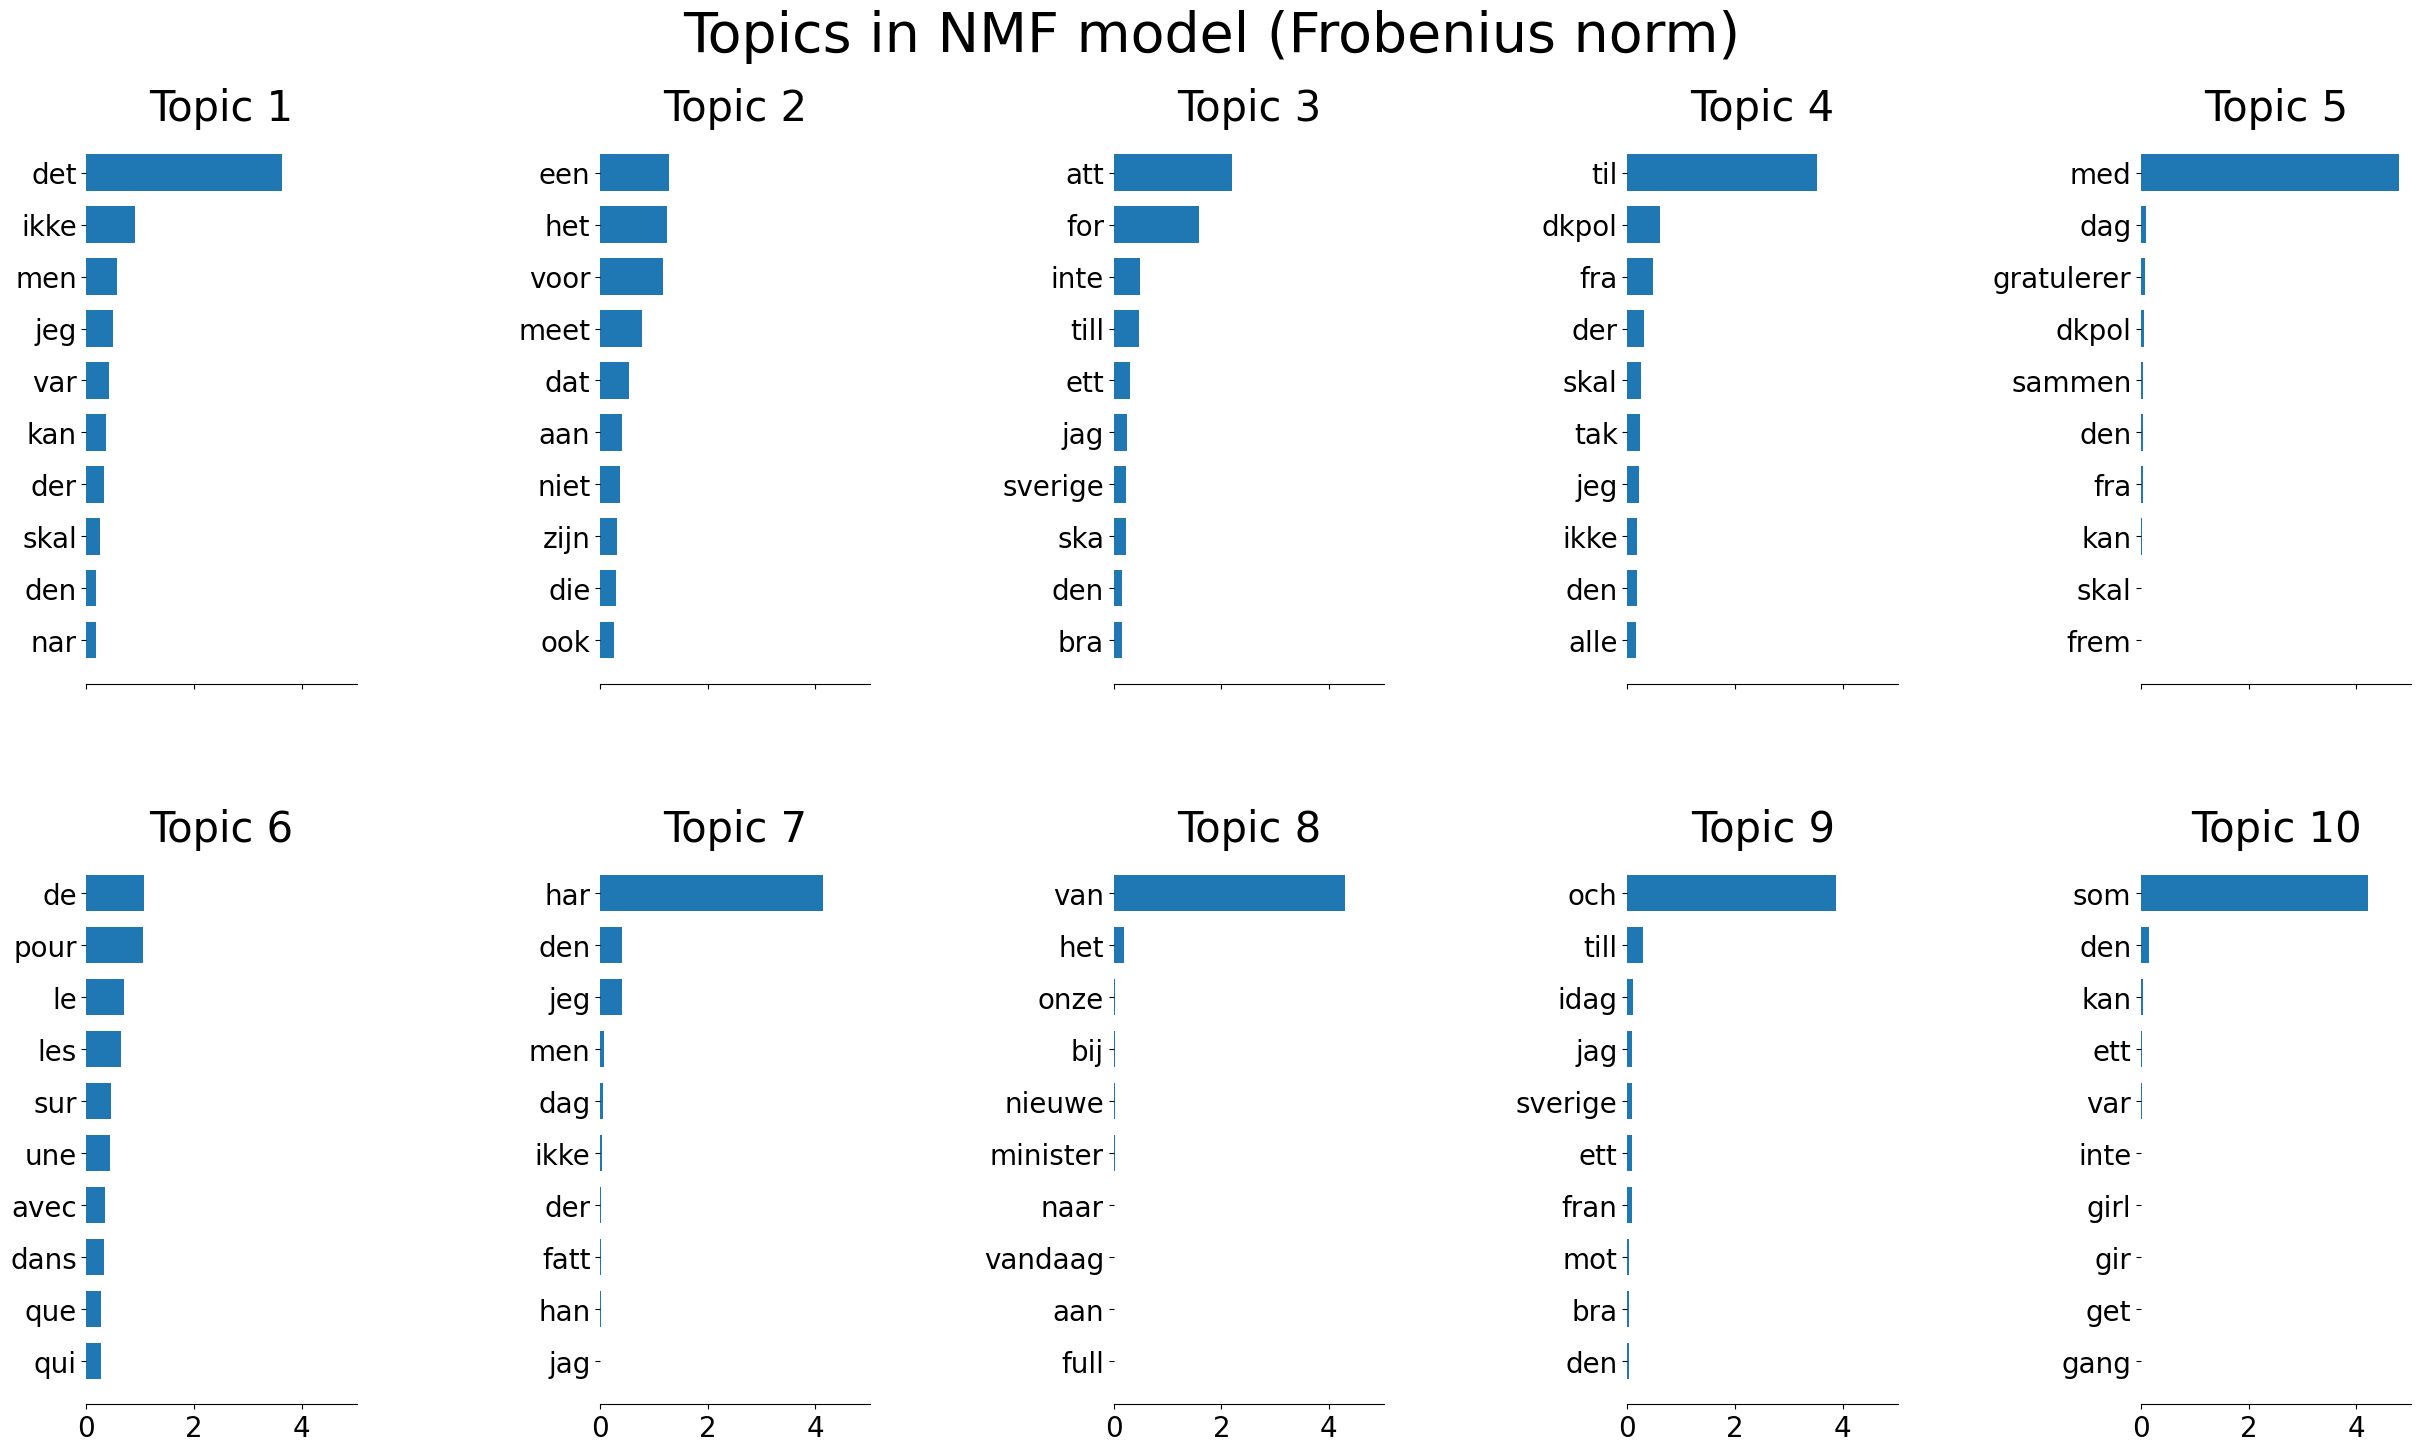



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=407223 and n_features=1000...
done in 71.078s.


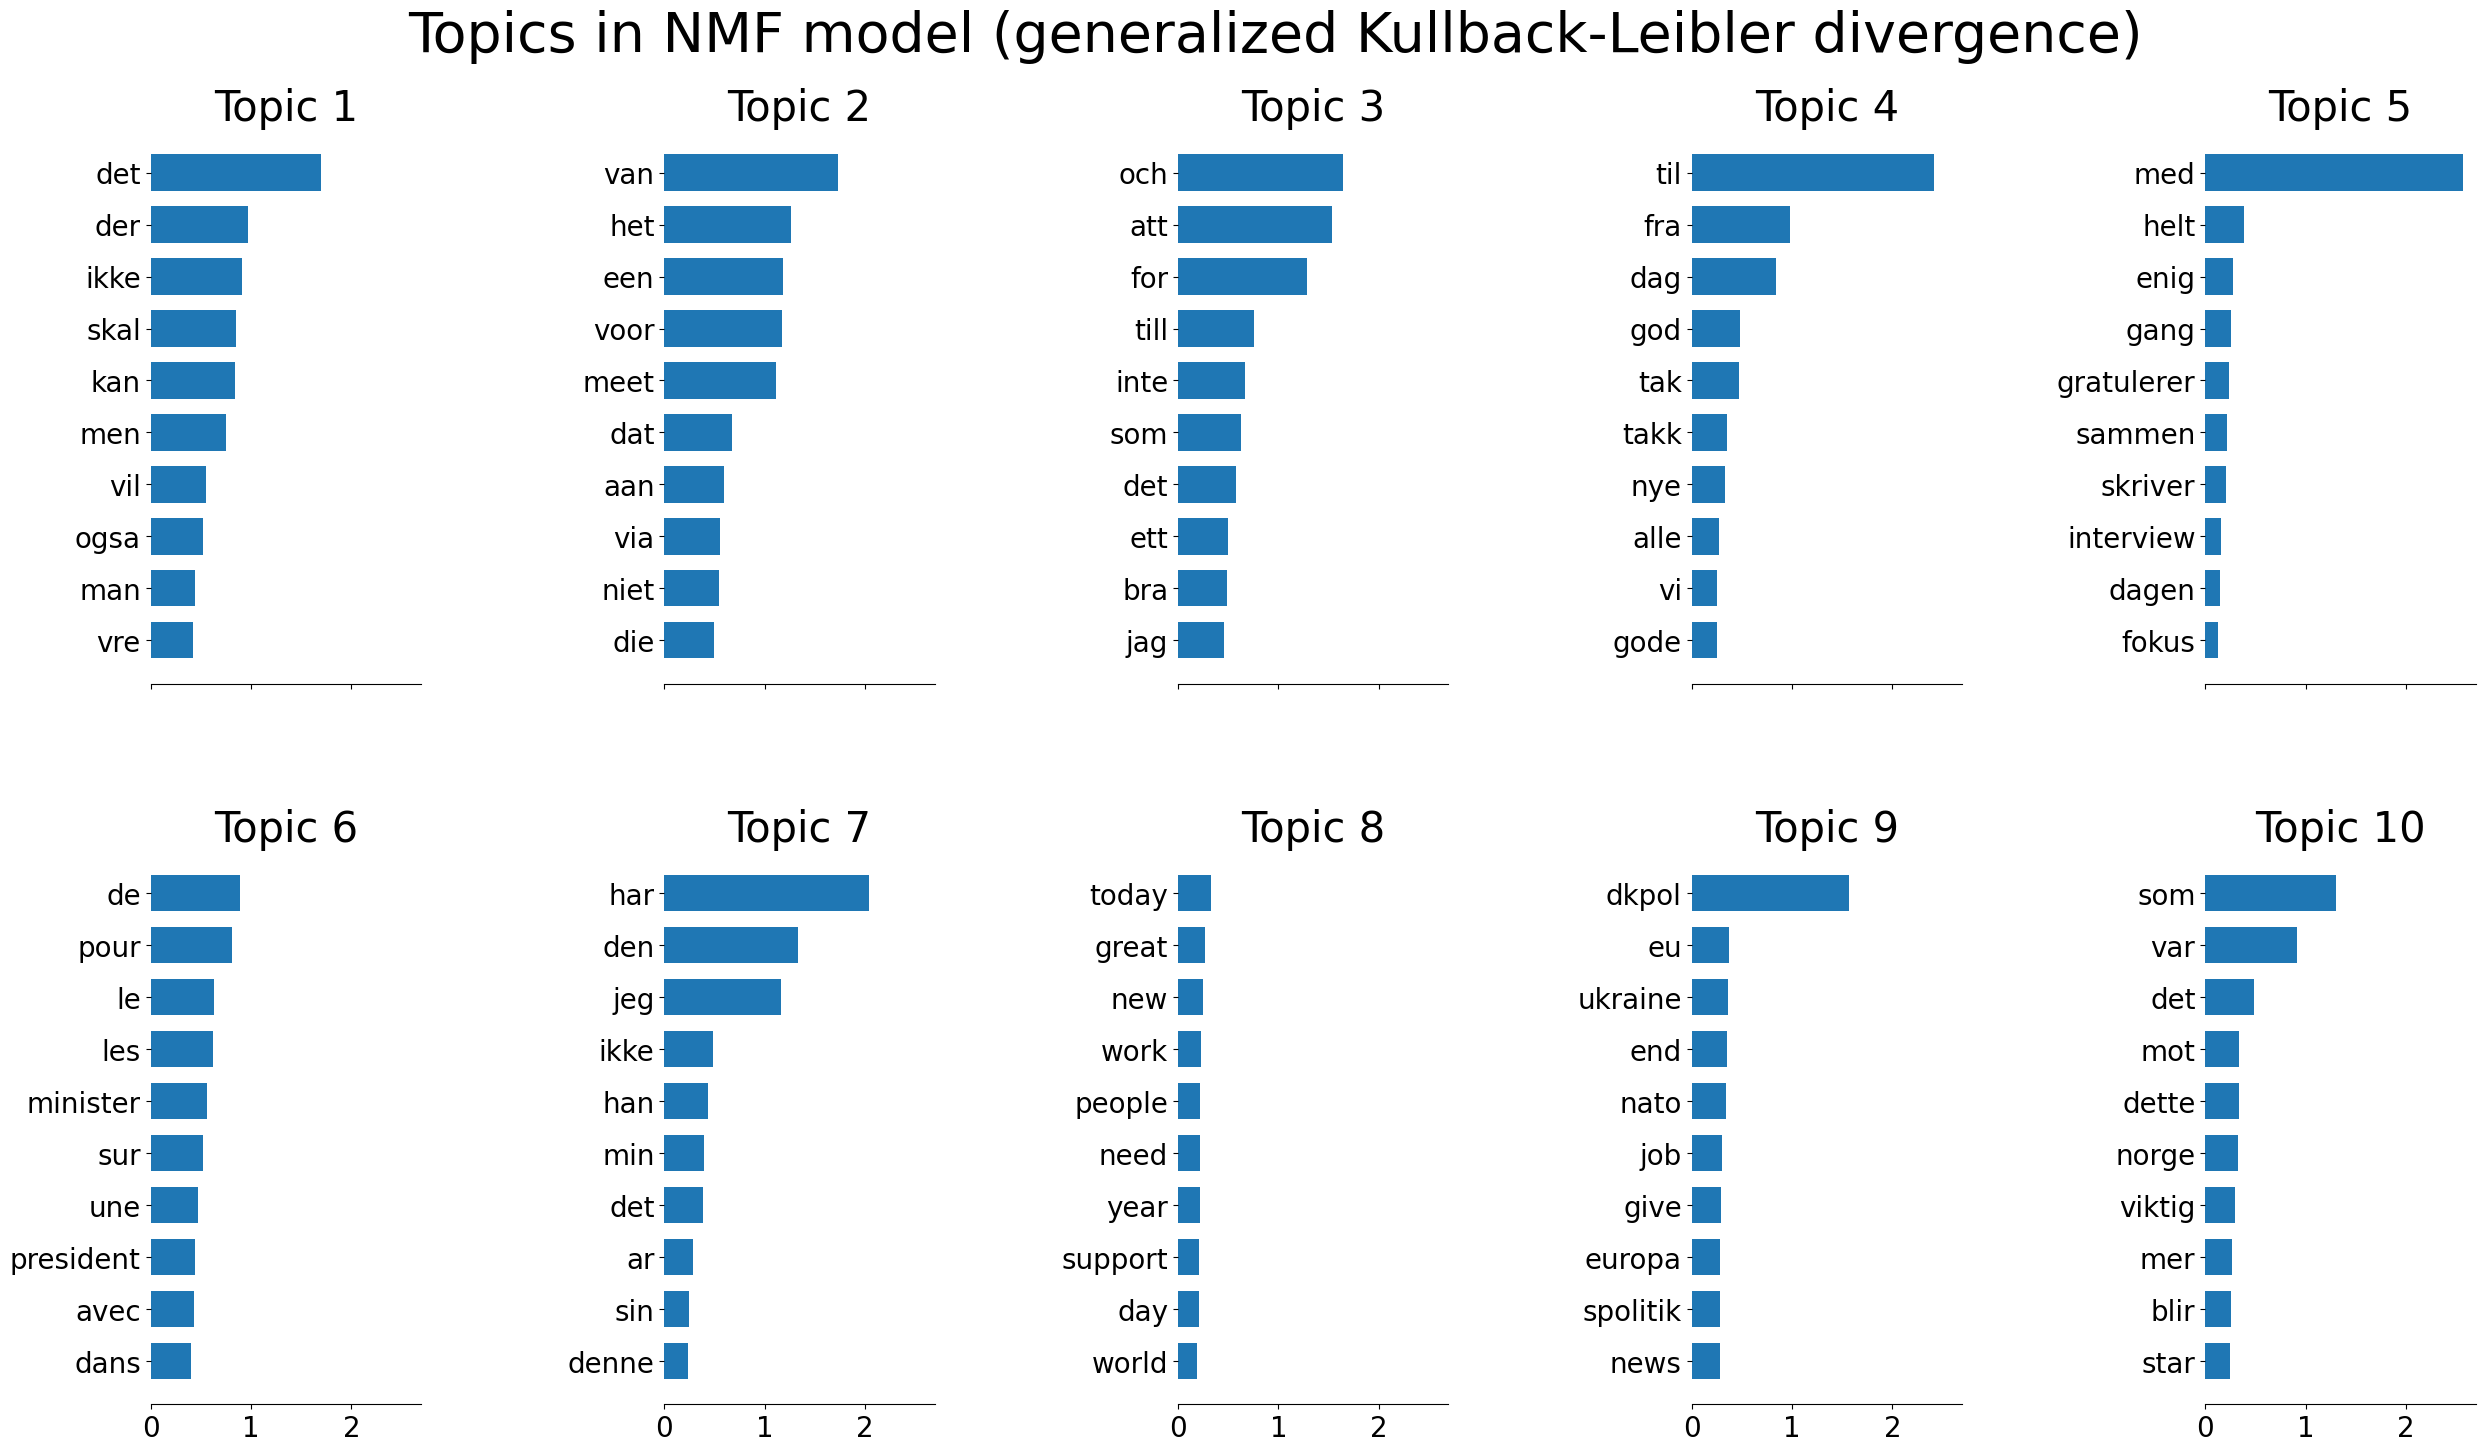



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=407223 and n_features=1000, batch_size=128...
done in 3.988s.


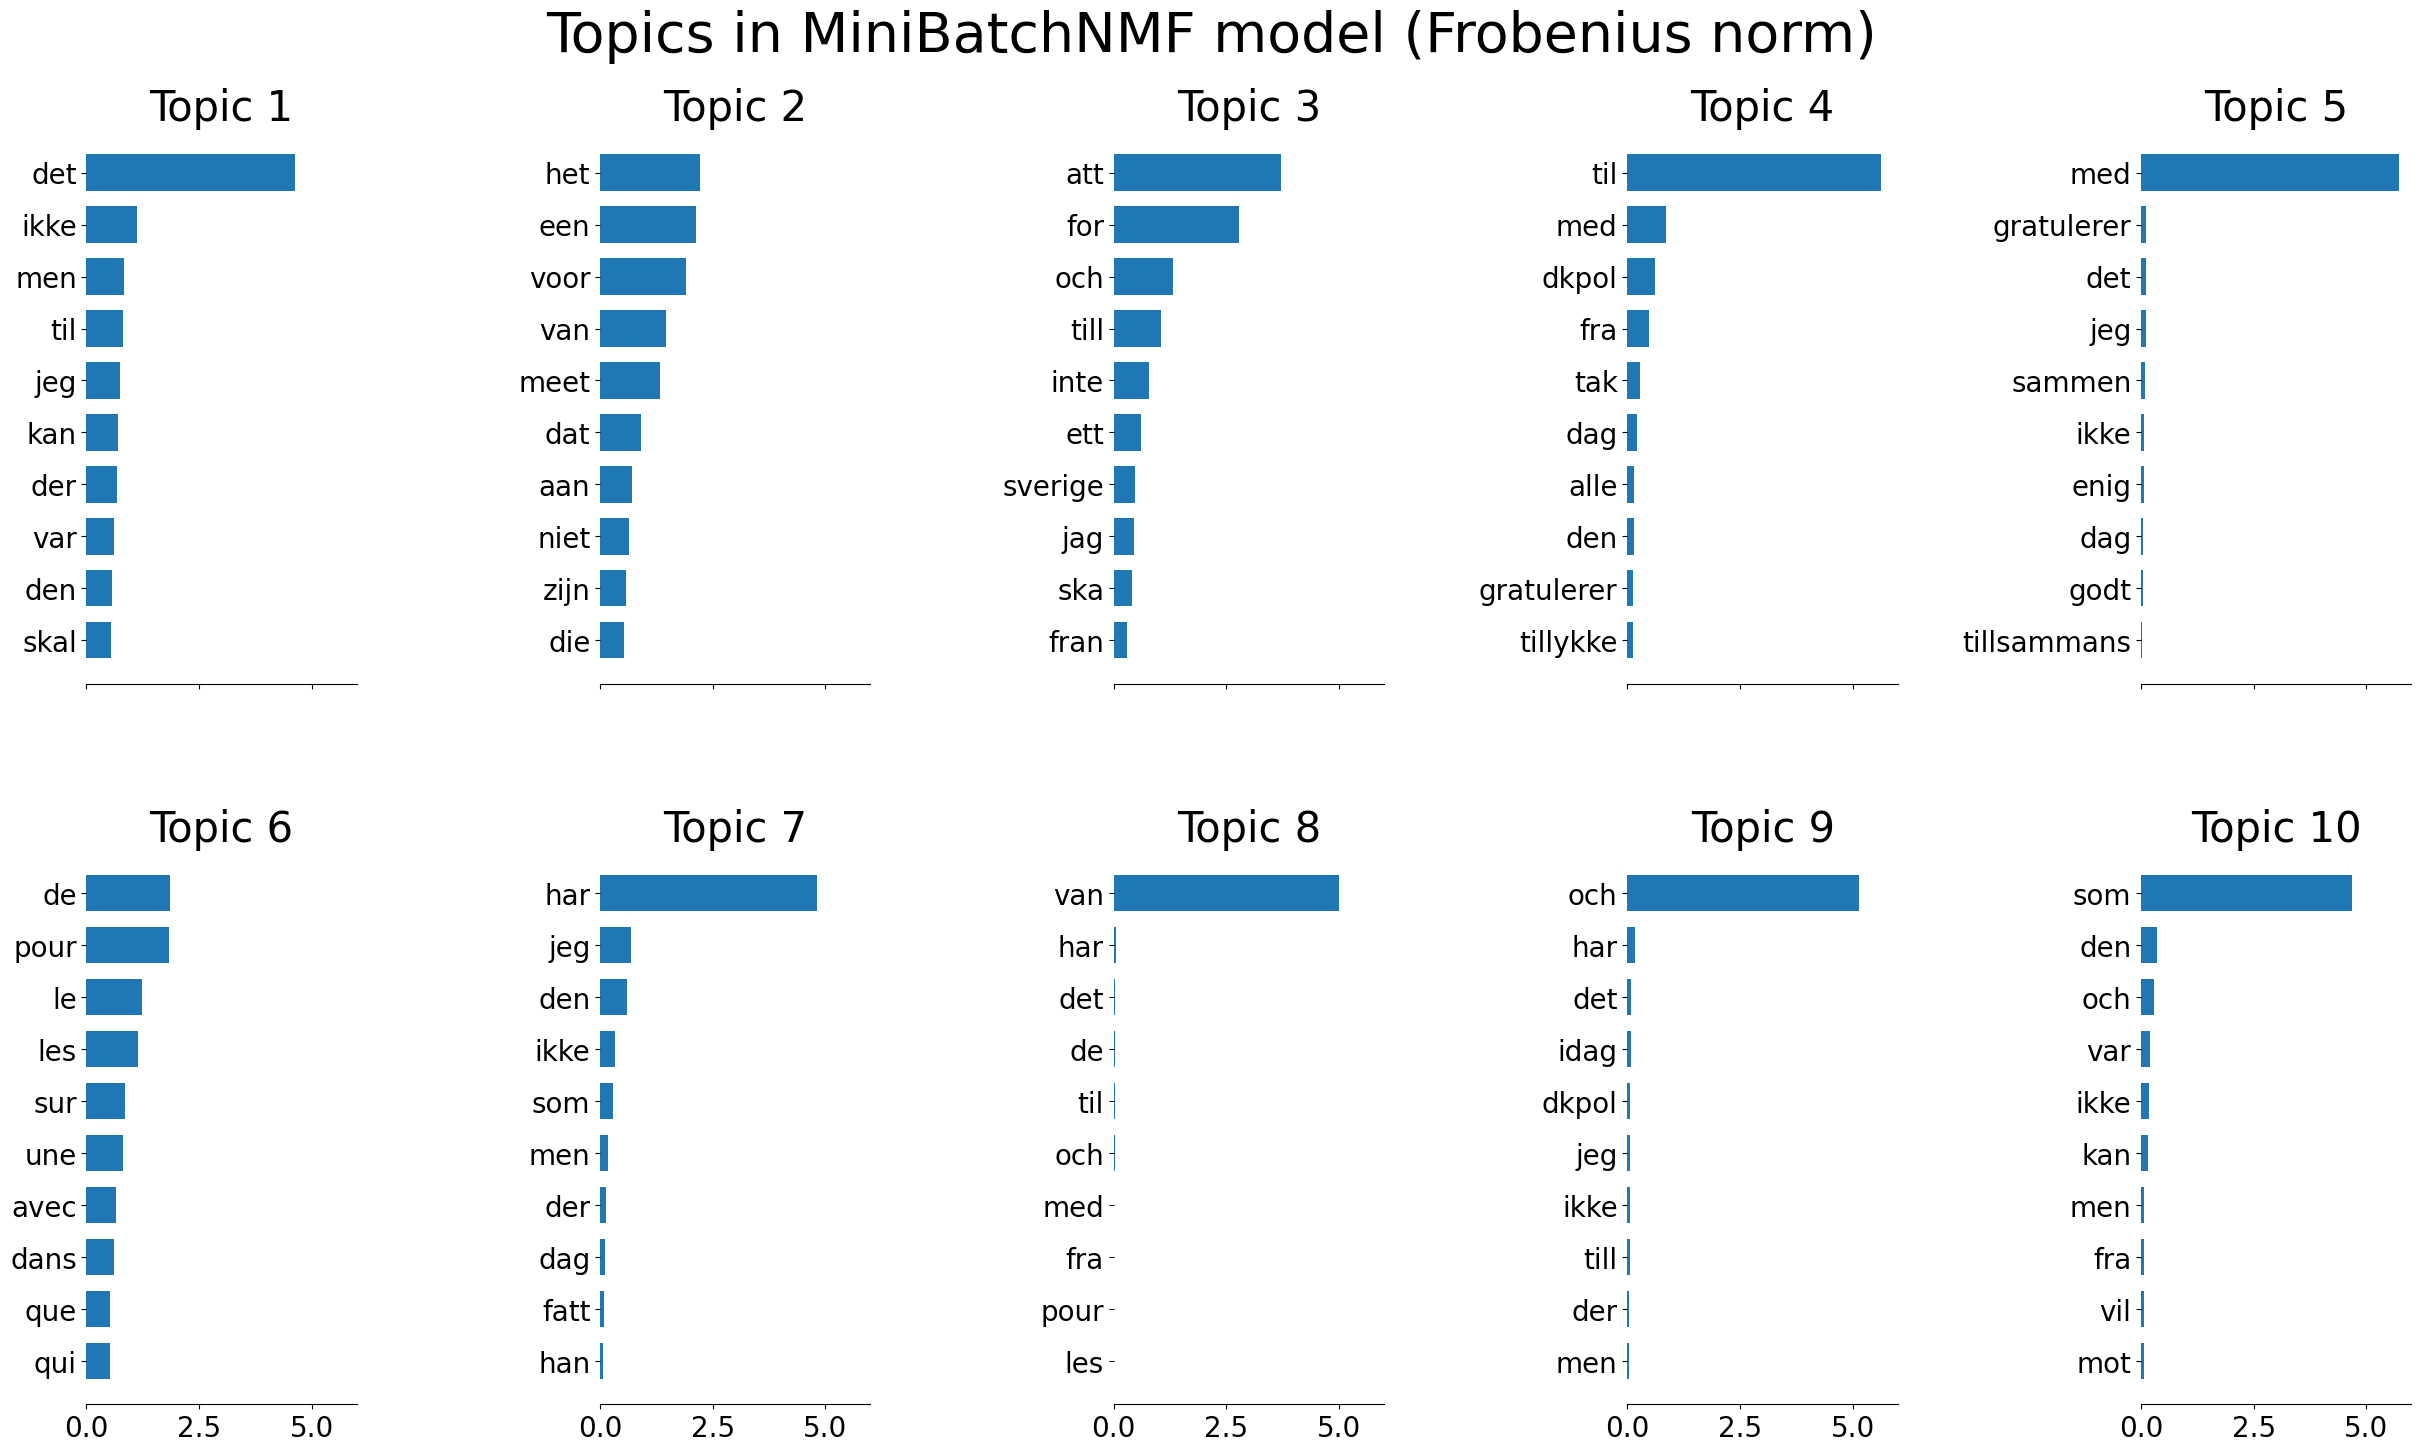



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=407223 and n_features=1000, batch_size=128...
done in 16.305s.


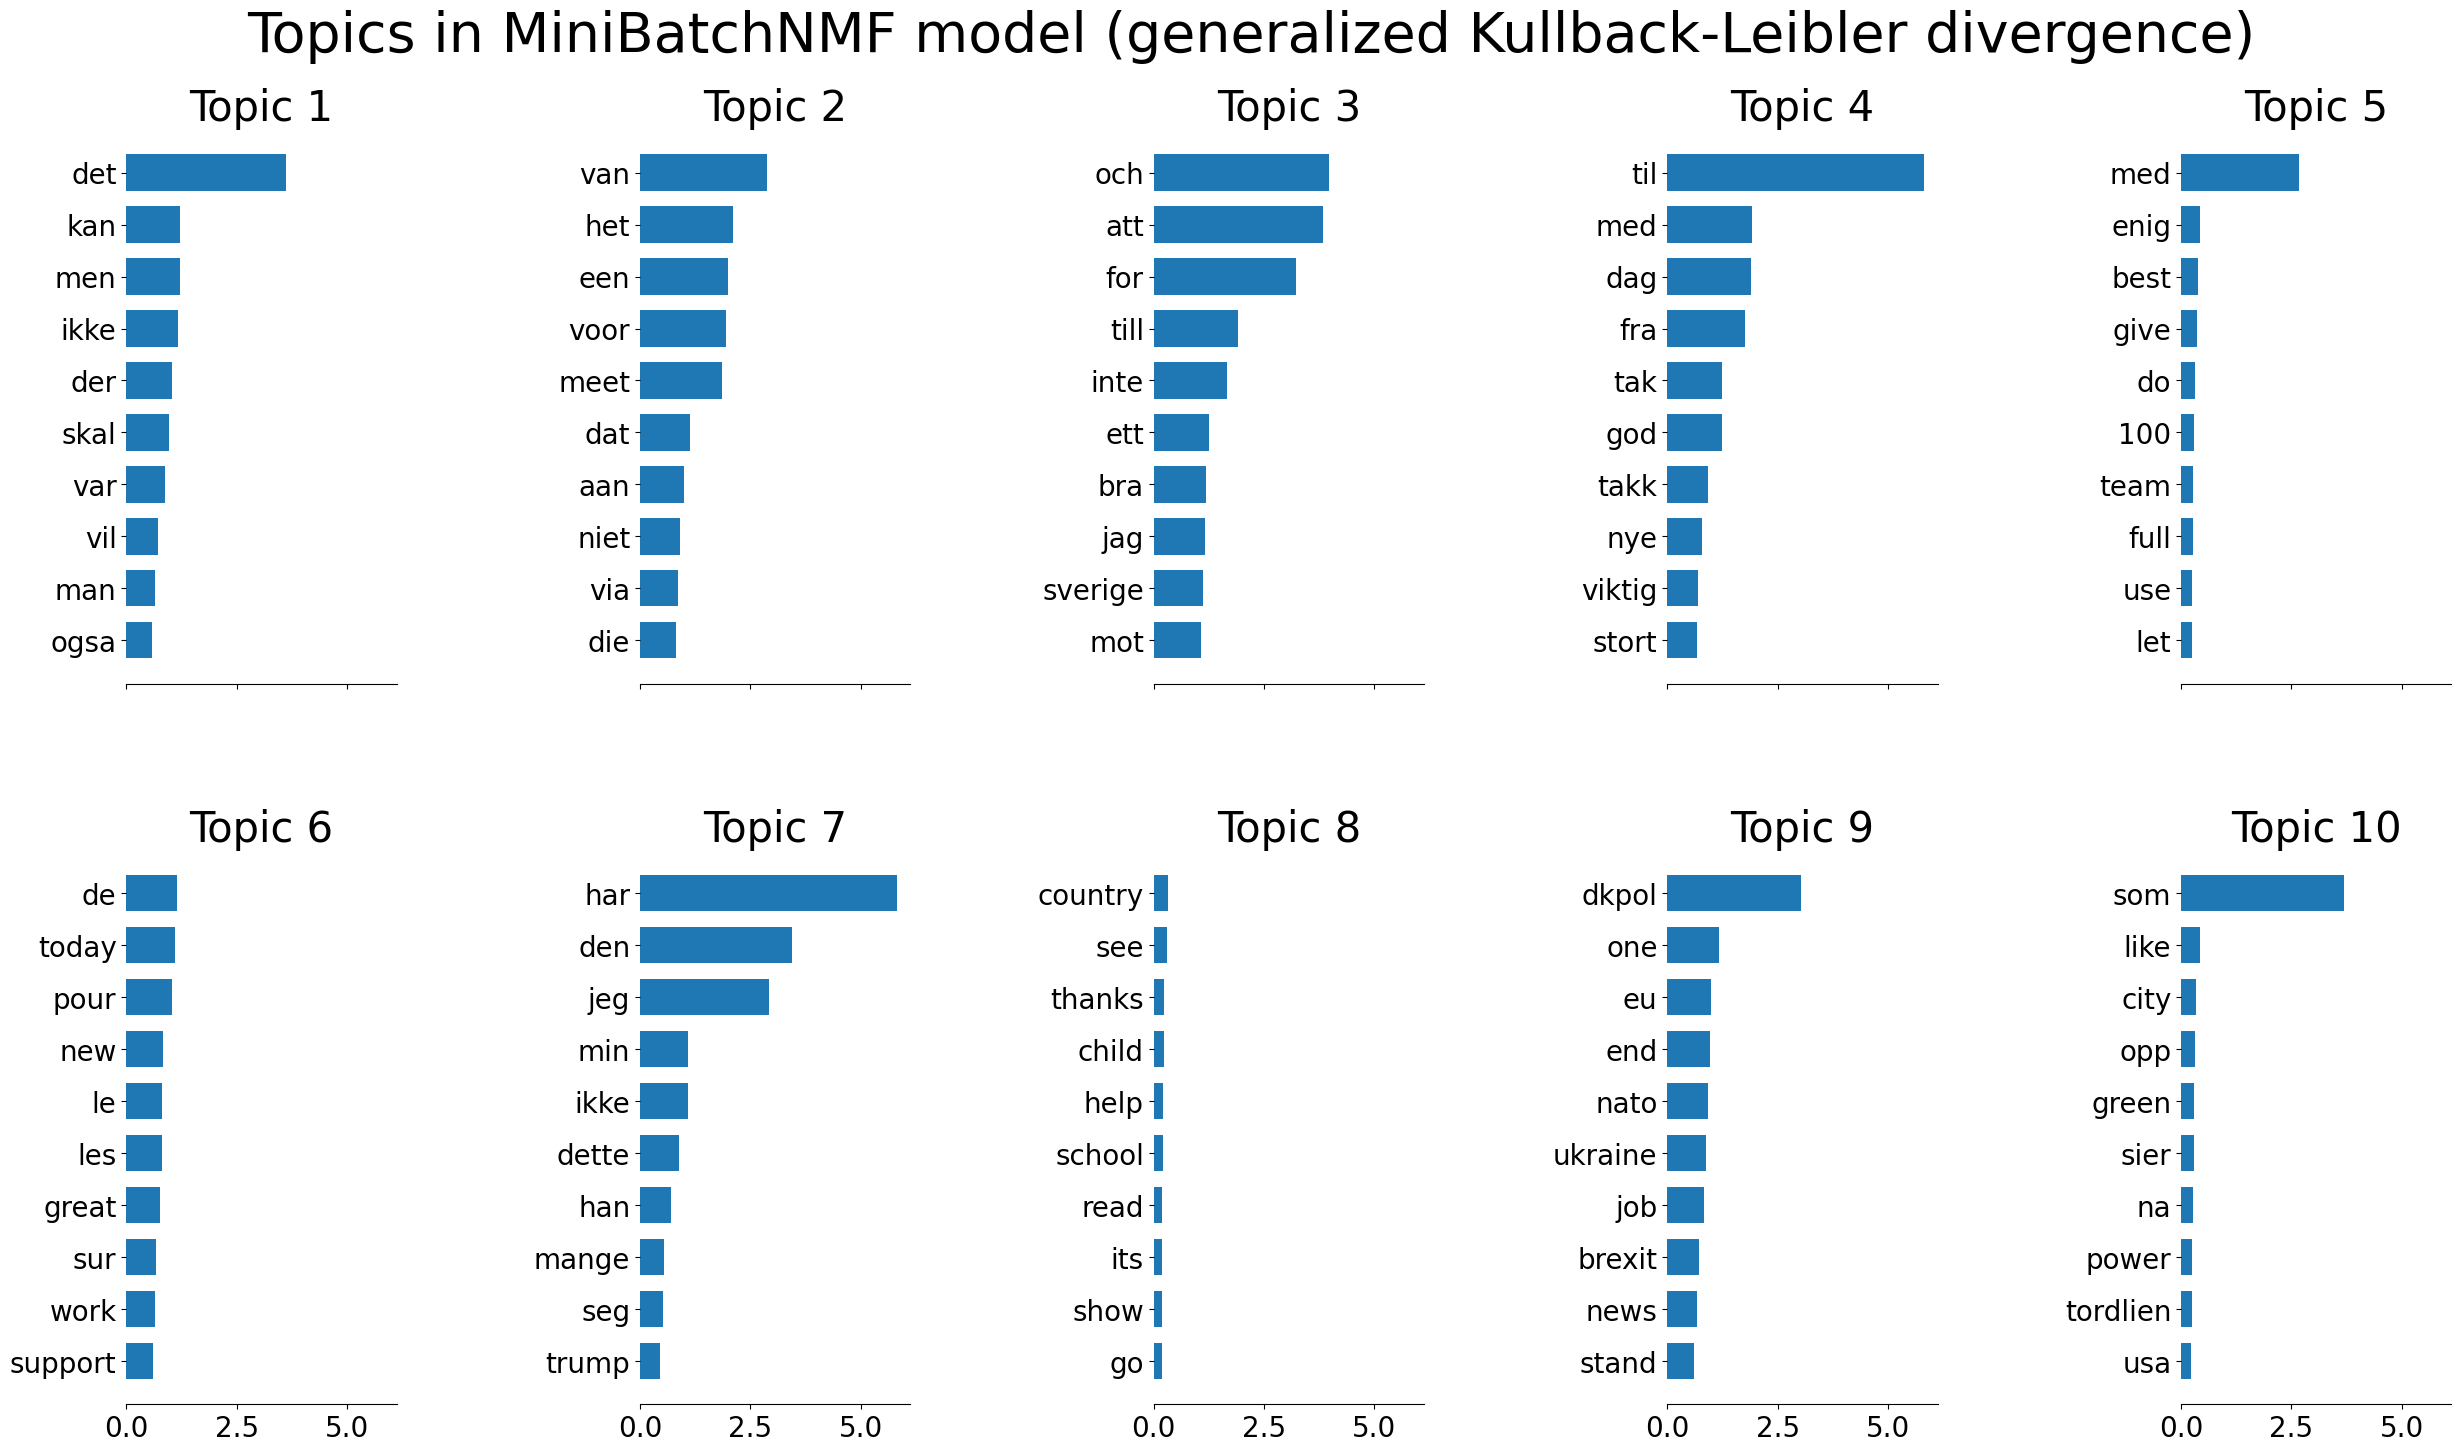



 Fitting LDA models with tf features, n_samples=407223 and n_features=1000...
done in 122.956s.


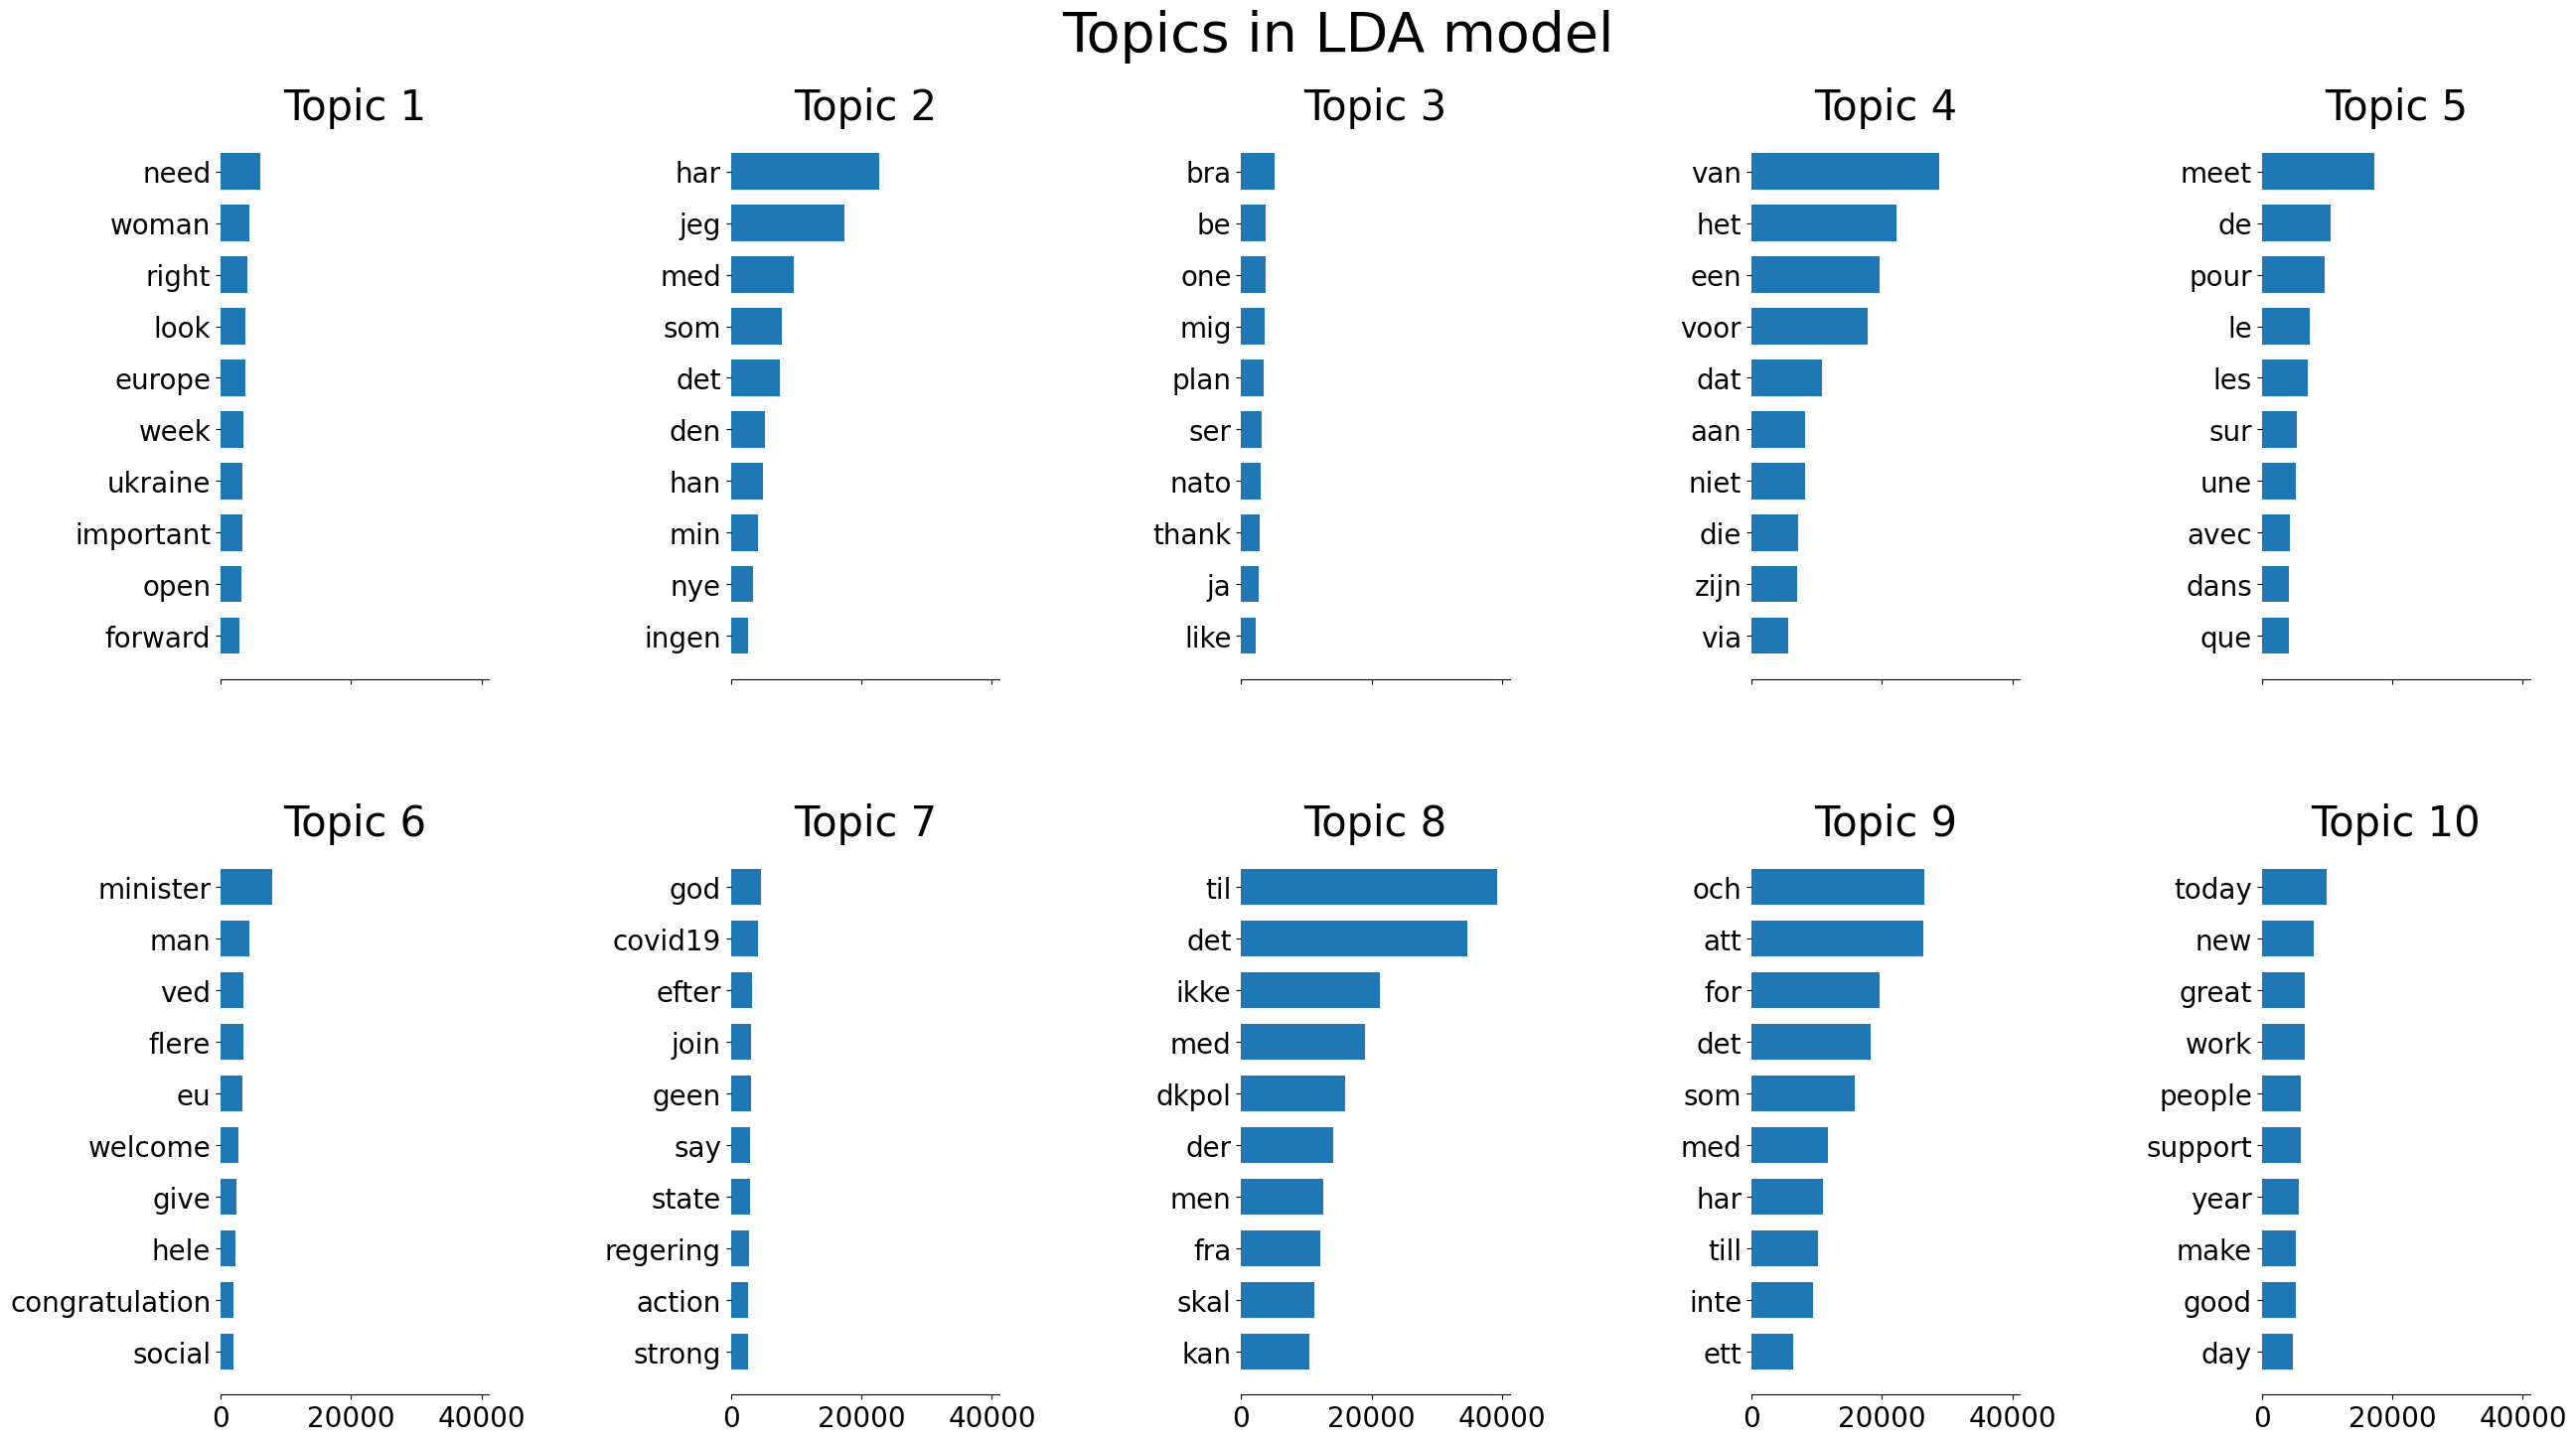

In [ ]:
data_samples = training_df['text_clean'].values
n_samples = len(data_samples)
n_features = 1000
n_components = 10
n_top_words = 10
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features)
t0 = t.time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (t.time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features)
t0 = t.time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (t.time() - t0))
print()

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = t.time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (t.time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = t.time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (t.time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = t.time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (t.time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = t.time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (t.time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = t.time()
lda.fit(tf)
print("done in %0.3fs." % (t.time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


In [ ]:
# Record the start time
start_time = t.time()

# Create a list of tweets from the DataFrame
tweets_list = test_df['full_text'].tolist()

# Create a Pool and map the parallelize_lemmatization function to each tweet
with Pool(processes=cpu_count()) as pool:
  text_clean = pool.map(lemmatize_tweet, tweets_list)

# Assign the cleaned tweets back to the DataFrame
test_df['text_clean'] = text_clean

# Stop the timer and report the elapsed time
end_time = t.time()
elapsed_time = end_time - start_time
print(f'The elapsed time is {elapsed_time}')


The elapsed time is 203.5523121356964


In [ ]:
# Save DataFrame
test_df.to_excel('./test_data_cleaned.xlsx', index=False)


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

training_df['hashtags_text_clean_country_gender_user'] = training_df.apply(
  lambda row: row['text_clean'] + ' ' + row['country_user'] + ' ' + row['gender_user'] + ' ' + (row['hashtags'] if pd.notna(row['hashtags']) else ''),
  axis=1
)
test_df['hashtags_text_clean_country_gender_user'] = test_df.apply(
  lambda row: row['text_clean'] + ' ' + row['country_user'] + ' ' + row['gender_user'] + ' ' + (row['hashtags'] if pd.notna(row['hashtags']) else ''),
  axis=1
)

X = training_df['hashtags_text_clean_country_gender_user']
y = training_df['pol_spec_user']
X_test = test_df['hashtags_text_clean_country_gender_user']


In [84]:
def show_confusion_matrix():
  cm = confusion_matrix(y, y_pred)

  class_names = np.unique(np.concatenate((y, y_pred)))

  plt.figure()
  sns.heatmap(cm, annot=True, fmt='g', cbar=False, xticklabels=class_names, yticklabels=class_names)

  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix', weight='bold')
  plt.show()


In [85]:
svc = Pipeline([
  ('vect', CountVectorizer(ngram_range=(1,2))),
  ('tfidf', TfidfTransformer()),
  ('clf', LinearSVC(max_iter=10000)),
])

# Predictions and evaluation
y_pred = cross_val_predict(svc, X, y, cv=10)
svc_accuracy = accuracy_score(y, y_pred)
svc_conf_matrix = confusion_matrix(y, y_pred)

svc.fit(X, y)
svc_predictions = svc.predict(X_test)

# Creating a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'ID': test_df['Id'].tolist(),
    'pol_spec_user': svc_predictions
})

predictions_df.to_csv('./submission_north_europe_svc.csv', index=False)

svc_accuracy


0.7696765654199296

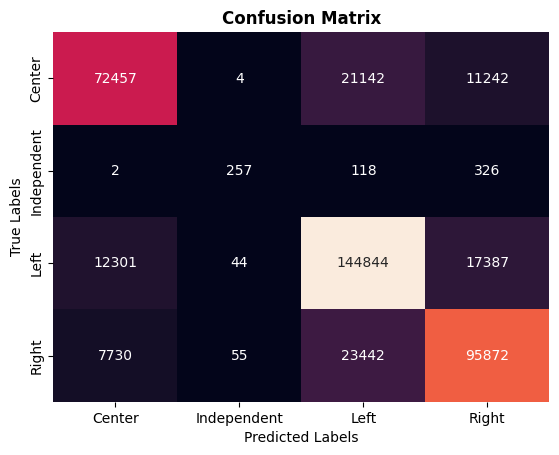

In [86]:
show_confusion_matrix()
